# Exercise 1


## Part I - accessing b-tagging discriminators

First let's import some useful thigs. For this part we will use __FWLite__, the python bindings to the edm CMSSW classes

In [1]:
import ROOT
import rootpy #hands down, a better version of PyROOT
import rootpy.plotting as plt
import pprint
from DataFormats.FWLite import Events, Handle

Welcome to JupyROOT 6.08/07


Then we load the input file

In [2]:
events = Events(
    'root://xrootd-cms.infn.it//store/mc/RunIISummer16MiniAODv3/TT_TuneCUETP8M2T4_13TeV-powheg-pythia8/MINIAODSIM/PUMoriond17_94X_mcRun2_asymptotic_v3-v1/00000/0A8930BA-88BE-E811-8BDD-20CF3027A582.root'
)

This is just a python trick to get the first event

In [3]:
event = events.__iter__().next()

Now, let's create a handle, like you would do in C++. If you use FWLite for your analysis, remember to create the handle __before your event loop!__ Creating a handle is quite slow in python, so better do it only once.

In [4]:
handle = Handle('vector<pat::Jet>')

Now get the jet collection

In [5]:
event.getByLabel('slimmedJets', handle)
jets = handle.product()
print jets

<ROOT.vector<pat::Jet> object at 0x1888d8a0>


Now that we have our vector of jets, we can check the first element and ask its methods.

B-tagging outputs are called _discriminator_, so let's use python's reflection abilities to see what's inside the `pat::Jet` that we can use. Otherwise you can always use [doxygen](http://cmsdoxygen.web.cern.ch/cmsdoxygen/CMSSW_9_2_8/doc/html/d6/d00/classpat_1_1Jet.html).

In [6]:
[i for i in dir(jets[0]) if 'disc' in i.lower()]

['addBDiscriminatorPair', 'bDiscriminator', 'getPairDiscri']

As you can see there are three methods that look interesting. One for adding the discriminators and two to get them, we will use the second one.

In [7]:
jets[0].getPairDiscri()

<ROOT.vector<pair<string,float> > object at 0x18935b80>

As you can see this returns a `std::vector` containing pairs of `std::string` and `float`, corresponding to the discriminator name and its respective value. Let's check all the discriminators available:

In [8]:
[i.first for i in jets[0].getPairDiscri()]

['pfJetBProbabilityBJetTags',
 'pfJetProbabilityBJetTags',
 'pfTrackCountingHighEffBJetTags',
 'pfSimpleSecondaryVertexHighEffBJetTags',
 'pfSimpleInclusiveSecondaryVertexHighEffBJetTags',
 'pfCombinedSecondaryVertexV2BJetTags',
 'pfCombinedInclusiveSecondaryVertexV2BJetTags',
 'softPFMuonBJetTags',
 'softPFElectronBJetTags',
 'pfCombinedMVAV2BJetTags',
 'pfCombinedCvsLJetTags',
 'pfCombinedCvsBJetTags',
 'pfDeepCSVJetTags:probb',
 'pfDeepCSVJetTags:probc',
 'pfDeepCSVJetTags:probudsg',
 'pfDeepCSVJetTags:probbb']

## Part II - A few comments on event loops

Let's run a simple event loop counting the events:

In [9]:
counter = 0
for evt in events:
    counter += 1
print counter

6500


OK, pretty standard, right? Now, let's try to do it __again__

In [10]:
counter = 0
for evt in events:
    counter += 1
print counter

0


#### What happened?
To save memory the `FWLite.Events` class behaves like a generator, hence once you loop over one entry, that entry is forgotten and you cannot re-run over it, unless you re-load the file completely. Keep that in mind when playing with it!

Let's reload the file, you can always re-execute this cell how many times you need to reset this feature and run on the full set of events

In [11]:
events = Events(
    'root://xrootd-cms.infn.it//store/mc/RunIISummer16MiniAODv3/TT_TuneCUETP8M2T4_13TeV-powheg-pythia8/MINIAODSIM/PUMoriond17_94X_mcRun2_asymptotic_v3-v1/00000/0A8930BA-88BE-E811-8BDD-20CF3027A582.root'
)

## Part III - plotting the b-tagging discriminator
Now, let's plot few discriminator outputs for jets with $p_T > 20$ GeV and $|\eta| < 2.4$

In [24]:
histograms = {
    'CSV' : plt.Hist(100,0,1.1),
    'deepCSV' : plt.Hist(100,0,1.1),
}

In [28]:
for event in events:
    event.getByLabel('slimmedJets', handle)
    jets = handle.product()
    for jet in jets:
        #some basic selections
        if jet.pt() < 20 or jet.eta() > 2.4: continue
        histograms['CSV'].fill(jet.bDiscriminator('pfCombinedInclusiveSecondaryVertexV2BJetTags'))
        histograms['deepCSV'].fill(
            jet.bDiscriminator('pfDeepCSVJetTags:probb') +
            jet.bDiscriminator('pfDeepCSVJetTags:probbb') #DeepCSV requires the sum of both!
        )

Now, let's plot it! (some cosmetics first, though)

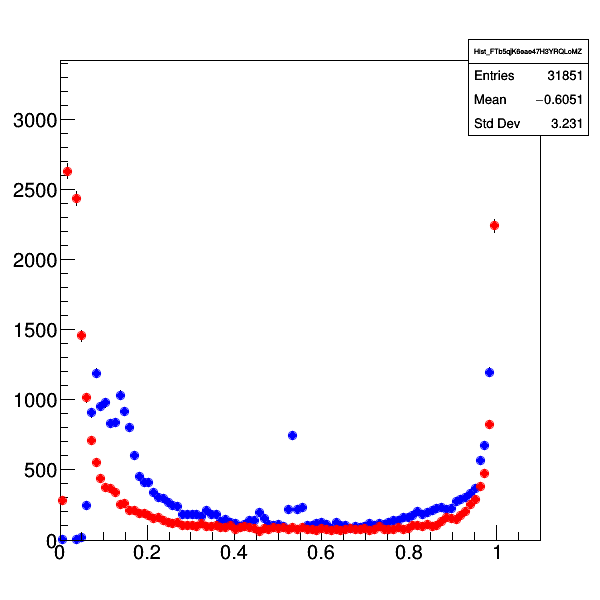

In [29]:
histograms['CSV'].markercolor = 'blue'
histograms['deepCSV'].markercolor = 'red'
histograms['deepCSV'].xaxis.title = 'DeepCSV'
histograms['deepCSV'].yaxis.title = 'Events'
canvas = plt.Canvas(600, 600)
histograms['CSV'].Draw()
histograms['deepCSV'].Draw('same')
canvas.Draw() #You need this to display inline